In [1]:
from xgboost import XGBRegressor
import xgboost as xgb
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skl2onnx.common.data_types import FloatTensorType
import numpy as np
from sklearn.preprocessing import StandardScaler
from skl2onnx import convert_sklearn
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from xgboost import plot_tree
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
    calculate_linear_regressor_output_shapes)
from onnxmltools.convert.xgboost.operator_converters.XGBoost import (
    convert_xgboost)
import onnxruntime as rt
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster
from matplotlib.pylab import rcParams

/Users/matthewwang/Library/Python/3.8/lib/python/site-packages/skl2onnx/algebra/onnx_ops.py:159: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  tys = obj.typeStr or ''
/Users/matthewwang/Library/Python/3.8/lib/python/site-packages/skl2onnx/algebra/automation.py:154: UserWarning: OpSchema.FormalParameter.isHomogeneous is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.is_homogeneous instead.
  if getattr(obj, 'isHomogeneous', False):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/jinja2/environment.py:485: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  return getattr(obj, attribute)


In [2]:
def get_crypto_price(symbol, exchange, start_date = None):
    api_key = 'Ommitted'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df


In [3]:
btc = get_crypto_price(symbol = 'BTC', exchange = 'USD', start_date = '2020-01-01')

In [4]:
btc['vol'] = (btc['high'] - btc['low']) / ((btc['open'] + btc['close']) / 2)
btc['vol-1'] = btc['vol'].shift(1)
btc['vol-2'] = btc['vol'].shift(2)
btc['vol-3'] = btc['vol'].shift(3)
btc['vol-4'] = btc['vol'].shift(4)
btc['vol-5'] = btc['vol'].shift(5)
btc = btc.iloc[5:]

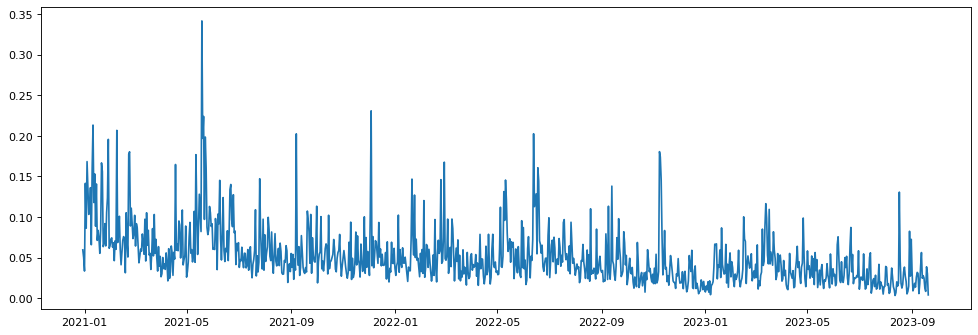

In [5]:
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(btc['vol'])

In [6]:
btc.describe()

,open,high,low,close,volume,vol,vol-1,vol-2,vol-3,vol-4,vol-5
count,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
mean,34746.191658,35633.374804,33746.659266,34746.087769,112643.568006,0.051590,0.051642,0.051665,0.051730,0.051814,0.051858
std,13013.695875,13412.120744,12532.662309,13013.980912,112333.163208,0.035450,0.035418,0.035412,0.035447,0.035444,0.035422
min,15781.290000,16315.000000,15476.000000,15781.290000,550.072220,0.003391,0.003391,0.003391,0.003391,0.003391,0.003391
25%,23504.905000,24197.270000,23082.975000,23504.905000,41512.296270,0.028266,0.028295,0.028295,0.028295,0.028319,0.028344
50%,30839.650000,31804.200000,30064.290000,30839.650000,66244.874920,0.043312,0.043418,0.043445,0.043490,0.043635,0.043637
75%,44466.235000,45904.465000,43093.505000,44466.235000,144198.066150,0.063552,0.063552,0.063552,0.063574,0.063584,0.063584
max,67525.820000,69000.000000,66222.400000,67525.830000,760705.362783,0.341587,0.341587,0.341587,0.341587,0.341587,0.341587


In [7]:
X = btc[['vol-1','vol-2','vol-3','vol-4','vol-5']]
y = btc['vol']

In [8]:
model = XGBRegressor(n_estimators = 100, random_state = 0, learning_rate = 0.1, max_depth=5)
model.fit(X.values, y.values)

[15:36:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=5)

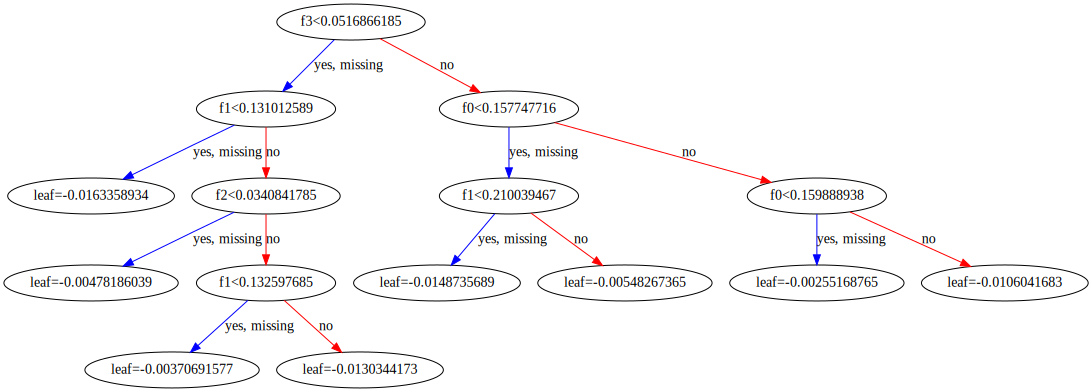

In [9]:
rcParams['figure.figsize'] = 10,10
xgb.to_graphviz(model, num_trees=10, rankdir='UD')

In [10]:
model.feature_importances_

array([0.21801023, 0.19327673, 0.19810645, 0.24007405, 0.15053251],
      dtype=float32)

In [11]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('xgb', XGBRegressor(n_estimators = 120, random_state = 0, learning_rate = 0.1, max_depth=7))])


In [12]:
pipe.fit(X.values, y.values)

[15:36:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb', XGBRegressor(max_depth=7, n_estimators=120))])

In [13]:
pipe.predict([X.values[1]])

array([0.05756411], dtype=float32)

In [15]:
# Convert to ONNX 
"""
update_registered_converter(
    XGBRegressor, 'XGBRegressor',
    calculate_linear_regressor_output_shapes, convert_xgboost)

model_onnx = to_onnx(pipe, X.astype(np.float32))
with open("Volatility.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())
"""


'\nupdate_registered_converter(\n    XGBRegressor, \'XGBRegressor\',\n    calculate_linear_regressor_output_shapes, convert_xgboost)\n\nmodel_onnx = to_onnx(pipe, X.astype(np.float32))\nwith open("Volatility.onnx", "wb") as f:\n    f.write(model_onnx.SerializeToString())\n'